# Flame AI


## Libraries

In [11]:
import cv2
import numpy as np
import cv2 as cv
import colorsys
import sys
import os
import imageio
import numpy as np
from PIL import Image
from lxml import etree
import pandas as pd
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
#from utils.util_scripts import is_intersection
import logging

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scipy.spatial import distance

ModuleNotFoundError: No module named 'imageio'

## Contour Functions


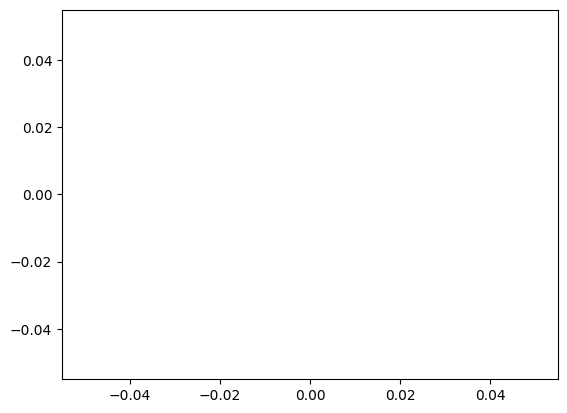

In [ ]:
###########BEST###################

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
areas = []
line, = ax.plot([], [])

def merge_contours(contours, max_distance=70):
    merged_contours = []
    used = [False] * len(contours)

    def get_centroid(contour):
        M = cv2.moments(contour)
        if M['m00'] == 0:
            return None
        return (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

    for i, c1 in enumerate(contours):
        if used[i]:
            continue
        merged = [c1]
        centroid1 = get_centroid(c1)
        if centroid1 is None:
            continue
        for j, c2 in enumerate(contours):
            if i != j and not used[j]:
                centroid2 = get_centroid(c2)
                if centroid2 is None:
                    continue
                dist = np.linalg.norm(np.array(centroid1) - np.array(centroid2))
                if dist < max_distance:  # Merge if within max_distance
                    merged.append(c2)
                    used[j] = True
        merged = np.vstack(merged)
        merged_contours.append(merged)
        used[i] = True

    return merged_contours

def extract_features(frame):
    img = frame[:, :, 1]
    img[0:40, :] = 0
    img[frame.shape[0] - 21:frame.shape[0] - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frame.shape[1] - 21:frame.shape[1] - 1] = 0

    _, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv2.morphologyEx(B2, cv2.MORPH_CLOSE, np.ones((10, 10)))

    contours, _ = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Merge contours that are close to each other
    contours = merge_contours(contours)

    features = {}
    for contour_id, c in enumerate(contours, start=1):
        if cv2.contourArea(c) > 100:
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height

            features[f'centerX_{contour_id}'] = center[0]
            features[f'centerY_{contour_id}'] = center[1]
            features[f'width_{contour_id}'] = width
            features[f'height_{contour_id}'] = height
            features[f'angle_{contour_id}'] = angle
            features[f'area_{contour_id}'] = area

    return features, B2, contours

def update_plot(frame_area):
    areas.append(frame_area)
    line.set_xdata(range(len(areas)))
    line.set_ydata(areas)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    all_features = []
    max_contours = 0
    contour_ids = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_features, B2, contours = extract_features(frame)
        current_ids = {}

        for contour_id, c in enumerate(contours, start=1):
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height
            centroid = (int(center[0]), int(center[1]))

            # Match contours with existing IDs
            matched = False
            for existing_id, existing_centroid in contour_ids.items():
                if np.linalg.norm(np.array(existing_centroid) - np.array(centroid)) < 50:  # Distance threshold
                    current_ids[existing_id] = centroid
                    frame_features[f'centerX_{existing_id}'] = center[0]
                    frame_features[f'centerY_{existing_id}'] = center[1]
                    frame_features[f'width_{existing_id}'] = width
                    frame_features[f'height_{existing_id}'] = height
                    frame_features[f'angle_{existing_id}'] = angle
                    frame_features[f'area_{existing_id}'] = area
                    matched = True
                    break

            if not matched:
                new_id = max(contour_ids.keys(), default=0) + 1
                current_ids[new_id] = centroid
                frame_features[f'centerX_{new_id}'] = center[0]
                frame_features[f'centerY_{new_id}'] = center[1]
                frame_features[f'width_{new_id}'] = width
                frame_features[f'height_{new_id}'] = height
                frame_features[f'angle_{new_id}'] = angle
                frame_features[f'area_{new_id}'] = area

        contour_ids = current_ids
        max_contours = max(max_contours, len(contours))
        all_features.append(frame_features)

        # Draw the contours
        for contour_id in contour_ids.keys():
            center_x = frame_features.get(f'centerX_{contour_id}')
            center_y = frame_features.get(f'centerY_{contour_id}')
            width = frame_features.get(f'width_{contour_id}')
            height = frame_features.get(f'height_{contour_id}')
            angle = frame_features.get(f'angle_{contour_id}')

            if center_x is not None and center_y is not None and width is not None and height is not None and angle is not None:
                box = cv2.boxPoints(((center_x, center_y), (width, height), angle))
                box = np.intp(box)
                frame = cv2.drawContours(frame, [box], 0, (255, 0, 0), 2)

        # Show the frame with bounding boxes
        cv2.imshow("preview", frame)
        if len(frame_features) > 0:
            total_area = sum((frame_features.get(f'width_{i+1}', 0) or 0) * (frame_features.get(f'height_{i+1}', 0) or 0)for i in range(max_contours))
            update_plot(total_area)

        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

    # Ensure all possible contour columns are present in every frame
    for frame in all_features:
        for contour_id in range(1, max_contours + 1):
            for feature in ['centerX', 'centerY', 'width', 'height', 'angle', 'area']:
                frame.setdefault(f'{feature}_{contour_id}', None)

    return all_features


## Main code


In [ ]:
# Process the video and get the feature vectors
movie_path = r"C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_Detector_5_24\Flame_train_AI\Flame_AI_test_video_2 - edit.mp4"
features = process_video(movie_path)

# Convert the flattened features to a DataFrame
df = pd.DataFrame(features)

# Save the DataFrame to a CSV file for later use
df.to_csv("fire_detection_features_corrected.csv", index=False)


## Test codes



In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


# Initialize plot
plt.ion()
fig, ax = plt.subplots()
areas = []
line, = ax.plot([], [])

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def merge_contours(contours, max_distance=70):
    merged_contours = []
    used = [False] * len(contours)

    def get_centroid(contour):
        M = cv2.moments(contour)
        if M['m00'] == 0:
            return None
        return (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

    for i, c1 in enumerate(contours):
        if used[i]:
            continue
        merged = [c1]
        centroid1 = get_centroid(c1)
        if centroid1 is None:
            continue
        for j, c2 in enumerate(contours):
            if i != j and not used[j]:
                centroid2 = get_centroid(c2)
                if centroid2 is None:
                    continue
                dist = np.linalg.norm(np.array(centroid1) - np.array(centroid2))
                if dist < max_distance:  # Merge if within max_distance
                    merged.append(c2)
                    used[j] = True
        merged = np.vstack(merged)
        merged_contours.append(merged)
        used[i] = True

    return merged_contours

def extract_features(frame):
    img = frame[:, :, 1]
    img[0:40, :] = 0
    img[frame.shape[0] - 21:frame.shape[0] - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frame.shape[1] - 21:frame.shape[1] - 1] = 0

    _, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv2.morphologyEx(B2, cv2.MORPH_CLOSE, np.ones((10, 10)))

    contours, _ = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Merge contours that are close to each other
    contours = merge_contours(contours)

    features = {}
    for contour_id, c in enumerate(contours, start=1):
        if cv2.contourArea(c) > 100:
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height

            features[f'centerX_{contour_id}'] = center[0]
            features[f'centerY_{contour_id}'] = center[1]
            features[f'width_{contour_id}'] = width
            features[f'height_{contour_id}'] = height
            features[f'angle_{contour_id}'] = angle
            features[f'area_{contour_id}'] = area

    return features, B2, contours

def update_plot(frame_area):
    areas.append(frame_area)
    line.set_xdata(range(len(areas)))
    line.set_ydata(areas)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

def preprocess_frame(frame):
    """Preprocess the frame to remove the top and bottom areas."""
    frame[0:40, :] = 0
    frame[-21:, :] = 0
    frame[:, 0:40] = 0
    frame[:, -40:] = 0
    return frame

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    all_features = []
    max_contours = 0
    contour_ids = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = preprocess_frame(frame)
        frame_features, B2, contours = extract_features(frame)
        current_ids = {}

        for contour_id, c in enumerate(contours, start=1):
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height
            centroid = (int(center[0]), int(center[1]))

            # Match contours with existing IDs
            matched = False
            for existing_id, existing_centroid in contour_ids.items():
                if np.linalg.norm(np.array(existing_centroid) - np.array(centroid)) < 50:  # Distance threshold
                    current_ids[existing_id] = centroid
                    frame_features[f'centerX_{existing_id}'] = center[0]
                    frame_features[f'centerY_{existing_id}'] = center[1]
                    frame_features[f'width_{existing_id}'] = width
                    frame_features[f'height_{existing_id}'] = height
                    frame_features[f'angle_{existing_id}'] = angle
                    frame_features[f'area_{existing_id}'] = area
                    matched = True
                    break

            if not matched:
                new_id = max(contour_ids.keys(), default=0) + 1
                current_ids[new_id] = centroid
                frame_features[f'centerX_{new_id}'] = center[0]
                frame_features[f'centerY_{new_id}'] = center[1]
                frame_features[f'width_{new_id}'] = width
                frame_features[f'height_{new_id}'] = height
                frame_features[f'angle_{new_id}'] = angle
                frame_features[f'area_{new_id}'] = area

        contour_ids = current_ids
        max_contours = max(max_contours, len(contours))
        all_features.append(frame_features)

        # Draw the contours
        for contour_id in contour_ids.keys():
            center_x = frame_features.get(f'centerX_{contour_id}')
            center_y = frame_features.get(f'centerY_{contour_id}')
            width = frame_features.get(f'width_{contour_id}')
            height = frame_features.get(f'height_{contour_id}')
            angle = frame_features.get(f'angle_{contour_id}')

            if center_x is not None and center_y is not None and width is not None and height is not None and angle is not None:
                box = cv2.boxPoints(((center_x, center_y), (width, height), angle))
                box = np.intp(box)
                frame = cv2.drawContours(frame, [box], 0, (255, 0, 0), 2)

        # Show the frame with bounding boxes
        cv2.imshow("preview", frame)
        if len(frame_features) > 0:
            total_area = sum((frame_features.get(f'width_{i+1}', 0) or 0) * (frame_features.get(f'height_{i+1}', 0) or 0) for i in range(max_contours))
            update_plot(total_area)

        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

    # Ensure all possible contour columns are present in every frame
    for frame in all_features:
        for contour_id in range(1, max_contours + 1):
            for feature in ['centerX', 'centerY', 'width', 'height', 'angle', 'area']:
                frame.setdefault(f'{feature}_{contour_id}', None)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_features)
    return df

def process_all_videos(video_folder, output_dir):
    video_times = []
    video_names = []

    for root, _, files in os.walk(video_folder):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.join(root, file)

                start_time = time.time()
                features = process_video(video_path)
                end_time = time.time()

                processing_time = end_time - start_time
                video_times.append(processing_time)
                video_names.append(file)


                if not features.empty:
                    base_name = os.path.splitext(os.path.basename(video_path))[0]
                    csv_file_path = os.path.join(root, f"{base_name}_features.csv")
                    features.to_csv(csv_file_path, index=False)
                    print(f"Features saved to {csv_file_path}")
                    # Process the extracted features for normalization and classification
                    process_features(csv_file_path, output_dir, file)


    plot_processing_times(video_names, video_times)

def plot_processing_times(video_names, video_times):
    plt.figure(figsize=(10, 6))
    plt.barh(video_names, video_times, color='skyblue')
    plt.xlabel('Processing Time (seconds)')
    plt.ylabel('Video File')
    plt.title('Processing Time for Each Video')
    plt.tight_layout()
    plt.show()

def process_features(csv_path, output_dir, video_name):
    df = pd.read_csv(csv_path)
    
    # Correct object ID extraction based on actual data
    object_ids = set(int(col.split('_')[-1]) for col in df.columns if '_' in col)
    
    # Create main directory based on video name
    main_dir = os.path.join(output_dir, os.path.splitext(video_name)[0])
    ensure_dir(main_dir)
    
    big_count = 1
    small_count = 1
    
    for object_id in object_ids:
        area_col = f"area_{object_id}"
        if area_col in df.columns:
            max_area = df[area_col].max()
            if max_area > 2000:
                object_type = f"big_{big_count}"
                big_count += 1
            else:
                object_type = f"small_{small_count}"
                small_count += 1
            
            object_dir = os.path.join(main_dir, object_type)
            ensure_dir(object_dir)
            
            # Include all needed parameters
            parameters = ['centerX', 'centerY', 'area', 'height', 'width', 'angle']
            data_collected = False  # Flag to check if any data is collected

            for param in parameters:
                param_name = f"{param}_{object_id}"
                if param_name in df.columns:
                    param_data = df[param_name].dropna().reset_index(drop=True)

                    # Create directory for each parameter
                    param_dir = os.path.join(object_dir, param)
                    ensure_dir(param_dir)

                    # Aggregate data with a sliding window of 20 frames
                    for start in range(0, len(param_data) - 19):  # ensure we have exactly 20 data points
                        frame_data = param_data[start:start+20]
                        if len(frame_data) == 20:  # Check if we indeed have 20 data points
                            # Normalize the data by dividing by the max of the 20 data points
                            max_value = frame_data.max()
                            normalized_data = frame_data / max_value
                            
                            # Create DataFrame, transpose and save to CSV without index and header
                            temp_df = pd.DataFrame([normalized_data]).transpose()  # Create and transpose DataFrame
                            vector_file_path = os.path.join(param_dir, f"{param}_{start}.csv")
                            temp_df.to_csv(vector_file_path, header=False, index=False)
                            data_collected = True
                
            if not data_collected:
                # Create an empty CSV file if no data was collected for this object
                empty_file_path = os.path.join(object_dir, "not_enough_information_for_this_object.csv")
                pd.DataFrame().to_csv(empty_file_path)

video_folder = r"C:\Users\talha\OneDrive\Desktop\CODE\train"
output_dir = r"C:\Users\talha\OneDrive\Desktop\CODE\after_code"
process_all_videos(video_folder, output_dir)


## MODEL

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Directory containing the CSV files
data_dir = r"C:\Users\talha\OneDrive\Desktop\CODE\after_code"

# Load all CSV files and combine them into a single DataFrame
data_frames = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.csv') and 'features' in file:
            df = pd.read_csv(os.path.join(root, file))
            data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)

# Assume we have a column 'label' to indicate fire (1) and non-fire (0)
# If not, you need to manually label your data
# Example: all_data['label'] = ...

# Select the features and labels
features = all_data[['centerX', 'centerY', 'area', 'height', 'width', 'angle']]
labels = all_data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_110507_644_features.csv.
Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_110818_653_features.csv.
Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_111453_656_features.csv.
Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_111640_661_features.csv.
Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_112824_670_features.csv.
Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_114332_673_features.csv.
Destination folder C:\Users\talha\OneDrive\Desktop\CODE\after_code\video does not exist. Skipping file video_20210627_114545_678_features.csv.

### AI

In [ ]:
class FireClassifier(nn.Module):
    def __init__(self, input_size):
        super(FireClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Assuming binary classification (fire or non-fire)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
model = FireClassifier(input_size)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed.")


### Load


### save

In [ ]:
#model.save_weights('Temporal_Model_A_weights_V5.h5')


### AI Test

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\first_video_20210627_122305_718_small fire_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\Flame_AI_test_video_1_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\Flame_AI_test_video_2 - edit_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\Flame_AI_test_video_2_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\video_20210406_074640_491_small_fire_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\video_20210406_075025_494_very_small_fire_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\video_20210406_075611_500_small_fire_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\video_20210406_080311_506_small_fire_features.csv
Features saved to C:\Users\talha\OneDrive\Desktop\CODE\train\video_20210406_080655_512_small_fire_features.csv
Features saved to C:\Users\t

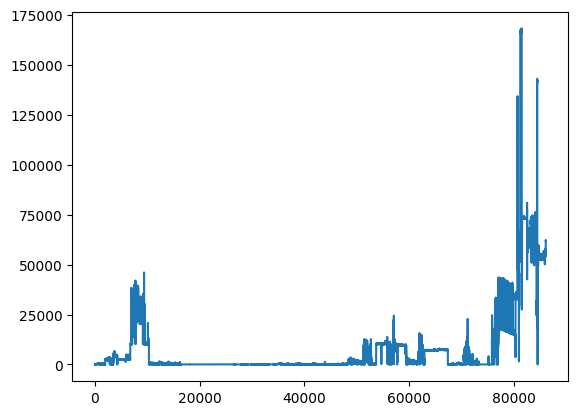

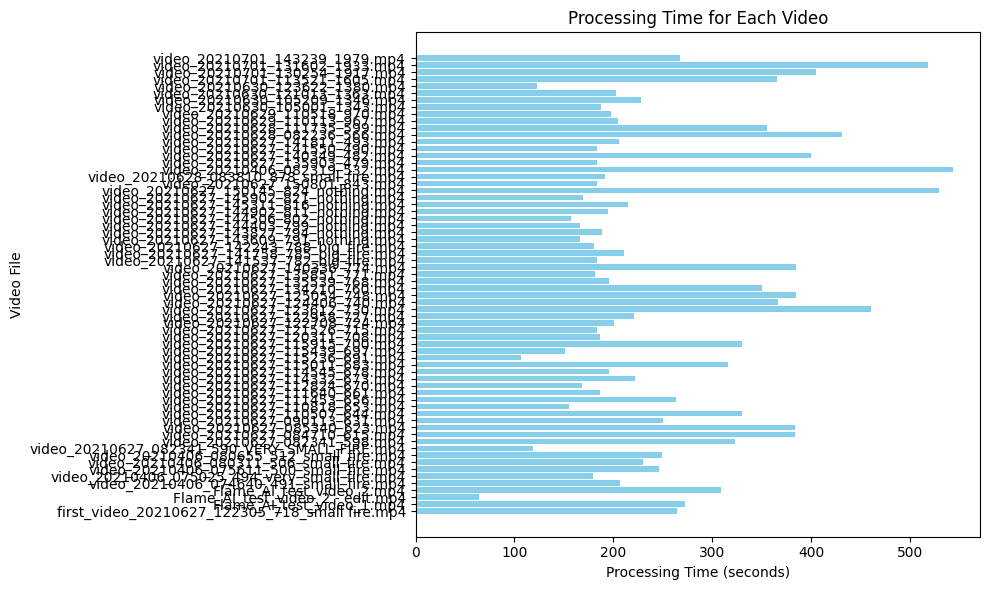

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


# Initialize plot
plt.ion()
fig, ax = plt.subplots()
areas = []
line, = ax.plot([], [])

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def merge_contours(contours, max_distance=70):
    merged_contours = []
    used = [False] * len(contours)

    def get_centroid(contour):
        M = cv2.moments(contour)
        if M['m00'] == 0:
            return None
        return (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

    for i, c1 in enumerate(contours):
        if used[i]:
            continue
        merged = [c1]
        centroid1 = get_centroid(c1)
        if centroid1 is None:
            continue
        for j, c2 in enumerate(contours):
            if i != j and not used[j]:
                centroid2 = get_centroid(c2)
                if centroid2 is None:
                    continue
                dist = np.linalg.norm(np.array(centroid1) - np.array(centroid2))
                if dist < max_distance:  # Merge if within max_distance
                    merged.append(c2)
                    used[j] = True
        merged = np.vstack(merged)
        merged_contours.append(merged)
        used[i] = True

    return merged_contours

def extract_features(frame):
    img = frame[:, :, 1]
    img[0:40, :] = 0
    img[frame.shape[0] - 21:frame.shape[0] - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frame.shape[1] - 21:frame.shape[1] - 1] = 0

    _, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv2.morphologyEx(B2, cv2.MORPH_CLOSE, np.ones((10, 10)))

    contours, _ = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Merge contours that are close to each other
    contours = merge_contours(contours)

    features = {}
    for contour_id, c in enumerate(contours, start=1):
        if cv2.contourArea(c) > 100:
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height

            features[f'centerX_{contour_id}'] = center[0]
            features[f'centerY_{contour_id}'] = center[1]
            features[f'width_{contour_id}'] = width
            features[f'height_{contour_id}'] = height
            features[f'angle_{contour_id}'] = angle
            features[f'area_{contour_id}'] = area

    return features, B2, contours

def update_plot(frame_area):
    areas.append(frame_area)
    line.set_xdata(range(len(areas)))
    line.set_ydata(areas)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

def preprocess_frame(frame):
    """Preprocess the frame to remove the top and bottom areas."""
    frame[0:40, :] = 0
    frame[-21:, :] = 0
    frame[:, 0:40] = 0
    frame[:, -40:] = 0
    return frame

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    all_features = []
    max_contours = 0
    contour_ids = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = preprocess_frame(frame)
        frame_features, B2, contours = extract_features(frame)
        current_ids = {}

        for contour_id, c in enumerate(contours, start=1):
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height
            centroid = (int(center[0]), int(center[1]))

            # Match contours with existing IDs
            matched = False
            for existing_id, existing_centroid in contour_ids.items():
                if np.linalg.norm(np.array(existing_centroid) - np.array(centroid)) < 50:  # Distance threshold
                    current_ids[existing_id] = centroid
                    frame_features[f'centerX_{existing_id}'] = center[0]
                    frame_features[f'centerY_{existing_id}'] = center[1]
                    frame_features[f'width_{existing_id}'] = width
                    frame_features[f'height_{existing_id}'] = height
                    frame_features[f'angle_{existing_id}'] = angle
                    frame_features[f'area_{existing_id}'] = area
                    matched = True
                    break

            if not matched:
                new_id = max(contour_ids.keys(), default=0) + 1
                current_ids[new_id] = centroid
                frame_features[f'centerX_{new_id}'] = center[0]
                frame_features[f'centerY_{new_id}'] = center[1]
                frame_features[f'width_{new_id}'] = width
                frame_features[f'height_{new_id}'] = height
                frame_features[f'angle_{new_id}'] = angle
                frame_features[f'area_{new_id}'] = area

        contour_ids = current_ids
        max_contours = max(max_contours, len(contours))
        all_features.append(frame_features)

        # Draw the contours
        for contour_id in contour_ids.keys():
            center_x = frame_features.get(f'centerX_{contour_id}')
            center_y = frame_features.get(f'centerY_{contour_id}')
            width = frame_features.get(f'width_{contour_id}')
            height = frame_features.get(f'height_{contour_id}')
            angle = frame_features.get(f'angle_{contour_id}')

            if center_x is not None and center_y is not None and width is not None and height is not None and angle is not None:
                box = cv2.boxPoints(((center_x, center_y), (width, height), angle))
                box = np.intp(box)
                frame = cv2.drawContours(frame, [box], 0, (255, 0, 0), 2)

        # Show the frame with bounding boxes
        cv2.imshow("preview", frame)
        if len(frame_features) > 0:
            total_area = sum((frame_features.get(f'width_{i+1}', 0) or 0) * (frame_features.get(f'height_{i+1}', 0) or 0) for i in range(max_contours))
            update_plot(total_area)

        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

    # Ensure all possible contour columns are present in every frame
    for frame in all_features:
        for contour_id in range(1, max_contours + 1):
            for feature in ['centerX', 'centerY', 'width', 'height', 'angle', 'area']:
                frame.setdefault(f'{feature}_{contour_id}', None)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_features)
    return df

def process_all_videos(video_folder, output_dir):
    video_times = []
    video_names = []

    for root, _, files in os.walk(video_folder):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.join(root, file)

                start_time = time.time()
                features = process_video(video_path)
                end_time = time.time()

                processing_time = end_time - start_time
                video_times.append(processing_time)
                video_names.append(file)


                if not features.empty:
                    base_name = os.path.splitext(os.path.basename(video_path))[0]
                    csv_file_path = os.path.join(root, f"{base_name}_features.csv")
                    features.to_csv(csv_file_path, index=False)
                    print(f"Features saved to {csv_file_path}")
                    # Process the extracted features for normalization and classification
                    process_features(csv_file_path, output_dir, file)


    plot_processing_times(video_names, video_times)

def plot_processing_times(video_names, video_times):
    plt.figure(figsize=(10, 6))
    plt.barh(video_names, video_times, color='skyblue')
    plt.xlabel('Processing Time (seconds)')
    plt.ylabel('Video File')
    plt.title('Processing Time for Each Video')
    plt.tight_layout()
    plt.show()

def process_features(csv_path, output_dir, video_name):
    df = pd.read_csv(csv_path)
    
    # Correct object ID extraction based on actual data
    object_ids = set(int(col.split('_')[-1]) for col in df.columns if '_' in col)
    
    # Create main directory based on video name
    main_dir = os.path.join(output_dir, os.path.splitext(video_name)[0])
    ensure_dir(main_dir)
    
    big_count = 1
    small_count = 1
    
    for object_id in object_ids:
        area_col = f"area_{object_id}"
        if area_col in df.columns:
            max_area = df[area_col].max()
            if max_area > 2000:
                object_type = f"big_{big_count}"
                big_count += 1
            else:
                object_type = f"small_{small_count}"
                small_count += 1
            
            object_dir = os.path.join(main_dir, object_type)
            ensure_dir(object_dir)
            
            # Include all needed parameters
            parameters = ['centerX', 'centerY', 'area', 'height', 'width', 'angle']
            data_collected = False  # Flag to check if any data is collected

            for param in parameters:
                param_name = f"{param}_{object_id}"
                if param_name in df.columns:
                    param_data = df[param_name].dropna().reset_index(drop=True)

                    # Create directory for each parameter
                    param_dir = os.path.join(object_dir, param)
                    ensure_dir(param_dir)

                    # Aggregate data with a sliding window of 20 frames
                    for start in range(0, len(param_data) - 19):  # ensure we have exactly 20 data points
                        frame_data = param_data[start:start+20]
                        if len(frame_data) == 20:  # Check if we indeed have 20 data points
                            # Normalize the data by dividing by the max of the 20 data points
                            max_value = frame_data.max()
                            normalized_data = frame_data / max_value
                            
                            # Create DataFrame, transpose and save to CSV without index and header
                            temp_df = pd.DataFrame([normalized_data]).transpose()  # Create and transpose DataFrame
                            vector_file_path = os.path.join(param_dir, f"{param}_{start}.csv")
                            temp_df.to_csv(vector_file_path, header=False, index=False)
                            data_collected = True
                
            if not data_collected:
                # Create an empty CSV file if no data was collected for this object
                empty_file_path = os.path.join(object_dir, "not_enough_information_for_this_object.csv")
                pd.DataFrame().to_csv(empty_file_path)

video_folder = r"C:\Users\talha\OneDrive\Desktop\CODE\train"
output_dir = r"C:\Users\talha\OneDrive\Desktop\CODE\after_code"
process_all_videos(video_folder, output_dir)
